<a href="https://colab.research.google.com/github/hdemma/hdemma.github.io/blob/master/Micro_Prediction_Models/EBusModel/Micro_EBUS_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Prior check of packages and versions

In [0]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)

scipy: 1.4.1
numpy: 1.18.4
matplotlib: 3.2.1
pandas: 1.0.3
statsmodels: 0.10.2
sklearn: 0.22.2.post1
theano: 1.0.4
tensorflow: 2.2.0
keras: 2.3.1


Using TensorFlow backend.


# Import required packages

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import math
from matplotlib import pyplot

# Load and pre-process data
## Combine two datasets: one dataset from spring, when temperature is lower, one from summer, when temperature is higher

In [0]:
dataset = pd.read_excel('Porcessed_BYD751_dataset.xlsm', index_col=False)
#print(dataset.head(6))
dataset['Speed2'] = dataset['Speed']**2
dataset['Speed3'] = dataset['Speed']**2
dataset['AccSpeed'] = dataset['Acc'] * dataset['Speed']
dataset['PowIndex'] = 1
neg_pow = dataset['Pow'] < 0
dataset.loc[neg_pow,'PowIndex'] = 0
#print(dataset.head(3))
#print(dataset[neg_pow].head(3))

## Filtering non-zero powers

In [0]:
non_zeropow = dataset['Pow'] != 0
print("Before filter, # of samples: ",dataset.shape[0])
dataset = dataset[non_zeropow]
print("After filter, # of samples: ",dataset.shape[0])

Before filter, # of samples:  332371
After filter, # of samples:  332277


## Reserve 20% data for testing

In [0]:
train = dataset.sample(n=math.floor(0.8*dataset.shape[0]))
test = dataset.sample(n=math.ceil(0.2*dataset.shape[0]))

## Split train and test data by vehicle status

In [0]:
train_accInd = train['Acc'] > 2
train_decInd = train['Acc'] < -2
train_crzInd = (train['Acc'] <= 2) & (train['Acc'] >= -2)
train_acc = train[train_accInd]
train_dec = train[train_decInd]
train_crz = train[train_crzInd]
print("# of acceleration samples for training: ", train_acc.shape[0])
print("# of decelearation samples for training: ", train_dec.shape[0])
print("# of cruizing samples for training: ", train_crz.shape[0])

crz_pos = train_crz['Pow'] > 0
crz_neg = train_crz['Pow'] <= 0
train_crz_pos = train_crz[crz_pos]
train_crz_neg = train_crz[crz_neg]
print("# of cruizing samples with positive power for training: ", train_crz_pos.shape[0])
print("# of cruizing samples with negative power for training: ", train_crz_neg.shape[0])

train_with_Speed = train_crz['Speed'] > 0
train_wSpeed = train_crz[train_with_Speed]
print("# of cruizing samples with positive speed for training: ", train_wSpeed.shape[0])

train_withSpeed_pos = train_wSpeed['Pow'] > 0
train_withSpeed_neg = train_wSpeed['Pow'] <= 0
train_wSpeed_pos = train_wSpeed[train_withSpeed_pos]
train_wSpeed_neg = train_wSpeed[train_withSpeed_neg]
print("# of cruizing samples with positive power and positive speed for training: ", train_wSpeed_pos.shape[0])
print("# of cruizing samples with negative power and positive speed for training: ", train_wSpeed_neg.shape[0])

# of acceleration samples for training:  25650
# of decelearation samples for training:  28192
# of cruizing samples for training:  211979
# of cruizing samples with positive power for training:  166946
# of cruizing samples with negative power for training:  45033
# of cruizing samples with positive speed for training:  208543
# of cruizing samples with positive power and positive speed for training:  163510
# of cruizing samples with negative power and positive speed for training:  45033


In [0]:
test_accInd = test['Acc'] > 2
test_decInd = test['Acc'] < -2
test_crzInd = (test['Acc'] <= 2) & (test['Acc'] >= -2)
test_acc = test[test_accInd]
test_dec = test[test_decInd]
test_crz = test[test_crzInd]
print("# of acceleration samples for testing: ", test_acc.shape[0])
print("# of decelearation samples for testing: ", test_dec.shape[0])
print("# of cruizing samples for testing: ", test_crz.shape[0])

test_withSpeed = test_crz['Speed'] >0
test_wSpeed = test_crz[test_withSpeed]
print("# of cruizing samples with positive speed for testing: ", test_wSpeed.shape[0])

# of acceleration samples for testing:  6463
# of decelearation samples for testing:  7150
# of cruizing samples for testing:  52843
# of cruizing samples with positive speed for testing:  51960


# Construct and compile models, using Mean Absolute Error for regression prediction models, Cross-entropy for power sign prediction model
# Fit each model seperately, each with 100 epochs and batch size is 32
## Performance vs epochs are ploted
* ### Model for accelerating status

In [0]:
Y_train_acc = train_acc['Pow']
X_train_acc = train_acc[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

Y_test_acc = test_acc['Pow']
X_test_acc = test_acc[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

model_acc = Sequential()
model_acc.add(Dense(10,kernel_initializer='normal', input_dim=9, activation ='relu'))
model_acc.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_acc.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_acc.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_acc.compile(loss='mean_absolute_error', optimizer='adam')

history = model_acc.fit(X_train_acc, Y_train_acc, validation_data=(X_test_acc, Y_test_acc), epochs=100, batch_size=32, verbose = 0)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

* ### Model for decelerating status

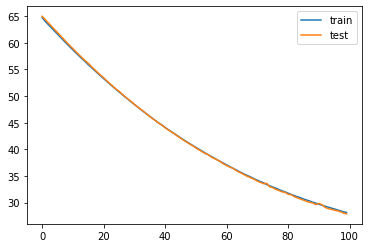

In [0]:
Y_train_dec = train_dec['Pow']
X_train_dec = train_dec[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

Y_test_dec = test_dec['Pow']
X_test_dec = test_dec[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

model_dec = Sequential()
model_dec.add(Dense(10,kernel_initializer='normal', input_dim=9, activation ='relu'))
model_dec.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_dec.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_dec.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_dec.compile(loss='mean_absolute_error', optimizer='adam')

history = model_dec.fit(X_train_dec, Y_train_dec, validation_data=(X_test_dec, Y_test_dec), epochs=100, batch_size=32, verbose = 0)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

* ### Model for predicting energy consuming or regenerative braking in cruizing status (sign of power)

Train on 211931 samples, validate on 53070 samples
Epoch 1/20
211931/211931 [==============================] - 9s 44us/step - loss: 0.4749 - accuracy: 0.8184 - val_loss: 0.6115 - val_accuracy: 0.6907
Epoch 2/20
211931/211931 [==============================] - 9s 43us/step - loss: 0.4011 - accuracy: 0.8370 - val_loss: 0.3498 - val_accuracy: 0.8553
Epoch 3/20
211931/211931 [==============================] - 9s 42us/step - loss: 0.3719 - accuracy: 0.8461 - val_loss: 0.3514 - val_accuracy: 0.8539
Epoch 4/20
211931/211931 [==============================] - 9s 43us/step - loss: 0.3580 - accuracy: 0.8508 - val_loss: 0.3496 - val_accuracy: 0.8549
Epoch 5/20
211931/211931 [==============================] - 9s 43us/step - loss: 0.3561 - accuracy: 0.8510 - val_loss: 0.3540 - val_accuracy: 0.8537
Epoch 6/20
211931/211931 [==============================] - 9s 43us/step - loss: 0.3535 - accuracy: 0.8519 - val_loss: 0.3447 - val_accuracy: 0.8554
Epoch 7/20
211931/211931 [=============================

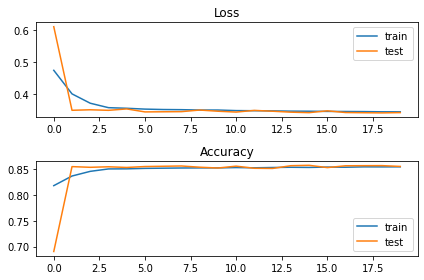

In [0]:
Y_train_ind = train_crz['PowIndex']
X_train_ind = train_crz[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

Y_test_ind = test_crz['PowIndex']
X_test_ind = test_crz[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

model_crzInd = Sequential()
model_crzInd.add(Dense(15, input_dim=9, activation ='relu'))
model_crzInd.add(Dense(8, activation ='relu'))
model_crzInd.add(Dense(4, activation ='relu'))
model_crzInd.add(Dense(1, activation ='sigmoid'))

model_crzInd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_crzInd.fit(X_train_ind, Y_train_ind, validation_data=(X_test_ind, Y_test_ind), epochs=20, batch_size=32, verbose = 1)

# evaluate the model
_, train_accuracy = model_crzInd.evaluate(X_train_ind, Y_train_ind, verbose=0)
_, test_accuracy = model_crzInd.evaluate(X_test_ind, Y_test_ind, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_accuracy, test_accuracy))

pyplot.subplot(211)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Loss')
pyplot.legend()

pyplot.subplot(212)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.title('Accuracy')
pyplot.legend()

pyplot.tight_layout()
pyplot.show()

* ### Model for positive power samples in cruizing status

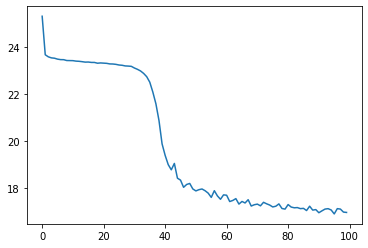

In [0]:
Y_train_pos = train_crz_pos['Pow']
X_train_pos = train_crz_pos[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

model_crzPos = Sequential()
model_crzPos.add(Dense(10,kernel_initializer='normal', input_dim=9, activation ='relu'))
model_crzPos.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_crzPos.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_crzPos.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_crzPos.compile(loss='mean_absolute_error', optimizer='adam')

history = model_crzPos.fit(X_train_pos, Y_train_pos, epochs=100, batch_size=32, verbose = 0)
pyplot.plot(history.history['loss'], label='train')
pyplot.show()

* ### Model for positive power samples in cruizing status

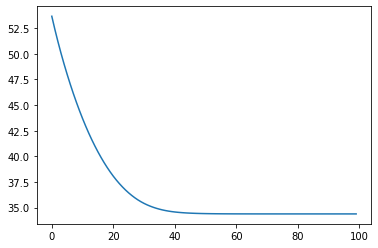

In [0]:
Y_train_neg = train_crz_neg['Pow']
X_train_neg = train_crz_neg[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

model_crzNeg = Sequential()
model_crzNeg.add(Dense(10,kernel_initializer='normal', input_dim=9, activation ='relu'))
model_crzNeg.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_crzNeg.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_crzNeg.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_crzNeg.compile(loss='mean_absolute_error', optimizer='adam')

history = model_crzNeg.fit(X_train_neg, Y_train_neg, epochs=100, batch_size=32, verbose = 0)
pyplot.plot(history.history['loss'], label='train')
pyplot.show()

## Some other models we are testing

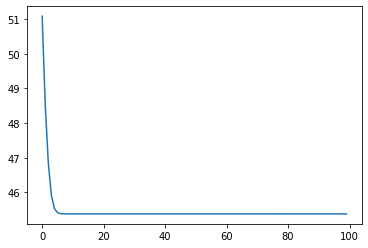

In [0]:
# Cruizing model
Y_train_crz = train_crz['Pow']
X_train_crz = train_crz[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

Y_test_crz = test_crz['Pow']
X_test_crz = test_crz[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

model_crz = Sequential()
model_crz.add(Dense(10,kernel_initializer='normal', input_dim=9, activation ='relu'))
model_crz.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_crz.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_crz.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_crz.compile(loss='mean_absolute_error', optimizer='adam')

history = model_crz.fit(X_train_crz, Y_train_crz, validation_data=(X_test_crz, Y_test_crz), epochs=100, batch_size=32, verbose = 0)
pyplot.plot(history.history['loss'], label='train')
pyplot.show()

Train on 208501 samples, validate on 52167 samples
Epoch 1/10
208501/208501 [==============================] - 5s 23us/step - loss: 36.8038 - val_loss: 33.5891
Epoch 2/10
208501/208501 [==============================] - 4s 20us/step - loss: 32.5039 - val_loss: 32.5838
Epoch 3/10
208501/208501 [==============================] - 4s 20us/step - loss: 32.2350 - val_loss: 32.5374
Epoch 4/10
208501/208501 [==============================] - 4s 21us/step - loss: 32.1699 - val_loss: 31.8648
Epoch 5/10
208501/208501 [==============================] - 4s 20us/step - loss: 32.1074 - val_loss: 31.6900
Epoch 6/10
208501/208501 [==============================] - 4s 21us/step - loss: 32.1063 - val_loss: 31.6470
Epoch 7/10
208501/208501 [==============================] - 4s 21us/step - loss: 32.0224 - val_loss: 32.7276
Epoch 8/10
208501/208501 [==============================] - 4s 21us/step - loss: 31.9960 - val_loss: 31.5677
Epoch 9/10
208501/208501 [==============================] - 4s 20us/step - lo

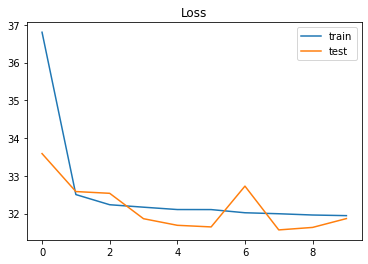

In [0]:
# Cruizing model for positive speed data
Y_train_wSpeed = train_wSpeed['Pow']
X__train_wSpeed = train_wSpeed[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

Y_test_wSpeed = test_wSpeed['Pow']
X_test_wSpeed = test_wSpeed[['Acc','Speed','RPM','Grade','Temp','Humidity','Speed2','Speed3','AccSpeed']]

model_crz = Sequential()
model_crz.add(Dense(10,kernel_initializer='normal', input_dim=9, activation ='relu'))
model_crz.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_crz.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_crz.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_crz.compile(loss='mean_absolute_error', optimizer='adam')

history = model_crz.fit(X__train_wSpeed, Y_train_wSpeed, validation_data=(X_test_wSpeed, Y_test_wSpeed), epochs=10, batch_size=64, verbose = 1)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Loss')
pyplot.legend()
pyplot.show()

# Make predictions and plot results